In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # function for splitting data to train and test sets

from wordcloud import WordCloud,STOPWORDS
import jieba
import matplotlib.pyplot as plt

- 从CSV文件中导入数据

In [3]:
data = pd.read_csv('datasets/dianping.csv')
data.head()

,comment,star
0,口味：不知道是我口高了，还是这家真不怎么样。??我感觉口味确实很一般很一般。上菜相当快，我敢...,2
1,菜品丰富质量好，服务也不错！很喜欢！,4
2,说真的，不晓得有人排队的理由，香精香精香精香精，拜拜！,2
3,菜量实惠，上菜还算比较快，疙瘩汤喝出了秋日的暖意，烧茄子吃出了大阪烧的味道，想吃土豆片也是口...,5
4,先说我算是娜娜家风荷园开业就一直在这里吃??每次出去回来总想吃一回??有时觉得外面的西式简餐...,4


* 数据预处理：通过star属性，准备sentiment属性

* 简单版分词

In [4]:


def word_cut (texts):
    words_list = []
    word_generator = jieba.cut(texts, cut_all=False)  # 返回的是一个迭代器
    with open('hit_stopwords.txt') as f:
        str_text = f.read()
    for word in word_generator:
        if word.strip() not in str_text:
            words_list.append(word)
            #print ('1')
    return ' '.join(words_list)  # 注意是空格

data['cut_comment'] = data.comment.apply(word_cut)

data.head()

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/8d/62lh93xj5lv9v1r3f8qg6m6r0000gn/T/jieba.cache
Loading model cost 1.320 seconds.
Prefix dict has been built succesfully.


,comment,star,cut_comment
0,口味：不知道是我口高了，还是这家真不怎么样。??我感觉口味确实很一般很一般。上菜相当快，我敢...,2,口味 知道 我口 高 这家 不怎么样 感觉 口味 确实 很 很 上菜 相当 快 我敢 菜 都...
1,菜品丰富质量好，服务也不错！很喜欢！,4,菜品 丰富 质量 服务 不错 很 喜欢
2,说真的，不晓得有人排队的理由，香精香精香精香精，拜拜！,2,说真的 晓得 有人 排队 理由 香精 香精 香精 香精 拜拜
3,菜量实惠，上菜还算比较快，疙瘩汤喝出了秋日的暖意，烧茄子吃出了大阪烧的味道，想吃土豆片也是口...,5,菜量 实惠 上菜 算 比较 快 喝出 秋日 暖意 烧茄子 吃 出 大阪 烧 味道 想 吃 土...
4,先说我算是娜娜家风荷园开业就一直在这里吃??每次出去回来总想吃一回??有时觉得外面的西式简餐...,4,先说 算是 娜娜 家风 荷园 开业 吃 每次 出去 回来 总想 吃 一回 有时 觉得 外面 ...


# 特征提取

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
# CountVectorizer

X = data['cut_comment']
y = data['star']
vect = TfidfVectorizer(max_df = 0.8, 
                       min_df = 3, 
                       token_pattern=u'(?u)\\b[^\\d\\W]\\w+\\b'
                      )
X_vec = vect.fit_transform(X) # 提取TF-IDF特征

# 模型训练

In [6]:
from sklearn.cluster import MiniBatchKMeans
mbk = MiniBatchKMeans(init='k-means++', n_clusters=5,
                      n_init=10, max_no_improvement=10)
y_kmeans= mbk.fit_predict(X_vec)

[[-0.00199953 -0.0496392 ]
 [ 0.18378959 -0.03737834]
 [-0.06894313 -0.00823587]
 ...
 [-0.08311352 -0.05252267]
 [-0.04755306 -0.04510337]
 [ 0.17700563  0.18693839]]


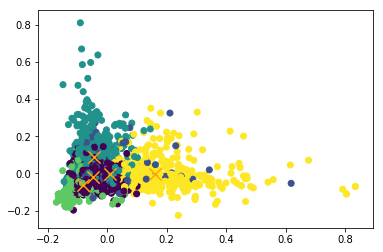

In [8]:
# reduce the features to 2D
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_X_vec = pca.fit_transform(X_vec.toarray())

print(reduced_X_vec)

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(mbk.cluster_centers_)

import matplotlib.pyplot as plt #Data Visualization 

plt.scatter(reduced_X_vec[:,0], reduced_X_vec[:,1], c=y_kmeans)
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='orange')


In [22]:
from sklearn import metrics

adjusted_mutual_info_s = metrics.adjusted_mutual_info_score(y, y_kmeans)
adjusted_mutual_info_s

0.09276689485016093

In [23]:
data['k_means'] = y_kmeans
data.head()

,comment,star,cut_comment,k_means
0,口味：不知道是我口高了，还是这家真不怎么样。??我感觉口味确实很一般很一般。上菜相当快，我敢...,2,口味 知道 我口 高 这家 不怎么样 感觉 口味 确实 很 很 上菜 相当 快 我敢 菜 都...,2
1,菜品丰富质量好，服务也不错！很喜欢！,4,菜品 丰富 质量 服务 不错 很 喜欢,0
2,说真的，不晓得有人排队的理由，香精香精香精香精，拜拜！,2,说真的 晓得 有人 排队 理由 香精 香精 香精 香精 拜拜,2
3,菜量实惠，上菜还算比较快，疙瘩汤喝出了秋日的暖意，烧茄子吃出了大阪烧的味道，想吃土豆片也是口...,5,菜量 实惠 上菜 算 比较 快 喝出 秋日 暖意 烧茄子 吃 出 大阪 烧 味道 想 吃 土...,1
4,先说我算是娜娜家风荷园开业就一直在这里吃??每次出去回来总想吃一回??有时觉得外面的西式简餐...,4,先说 算是 娜娜 家风 荷园 开业 吃 每次 出去 回来 总想 吃 一回 有时 觉得 外面 ...,2
